In [2]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [3]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

In [4]:
# explore fluid input and echo
sql = """
SELECT *
  FROM mimiciii.test_echo_fluid2
  """
df = pd.read_sql_query(sql, conn)

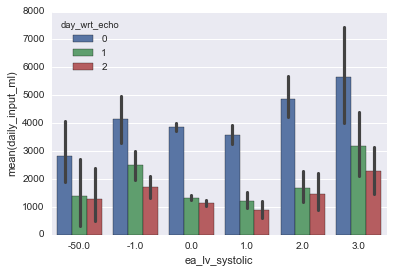

In [5]:
sns.barplot(x="ea_lv_systolic", y="daily_input_ml", hue ="day_wrt_echo", data=df[df.day_wrt_echo.isin([0, 1, 2])])

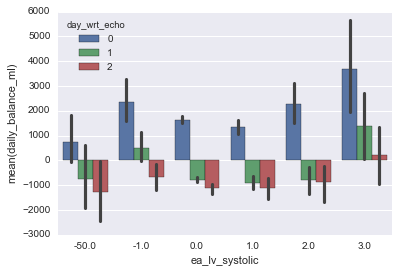

In [27]:
sns.barplot(x="ea_lv_systolic", y="daily_balance_ml", hue ="day_wrt_echo", data=df[df.day_wrt_echo.isin([0, 1, 2])])

In [34]:
df[['ea_lv_systolic']].groupby(['ea_lv_systolic']).size()

ea_lv_systolic
-50.0      52
-1.0      595
 0.0     5409
 1.0      726
 2.0      260
 3.0      232
dtype: int64

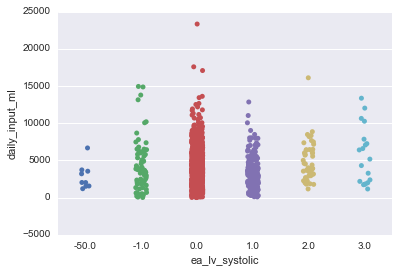

In [29]:
sns.stripplot(x="ea_lv_systolic", y="daily_input_ml", data=df[df.day_wrt_echo.isin([0])], jitter = True)

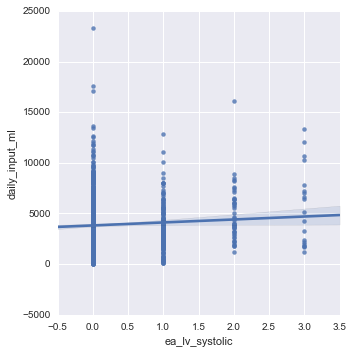

In [37]:
sns.lmplot(x="ea_lv_systolic", y="daily_input_ml", data=df[df.day_wrt_echo.isin([0]) & df.ea_lv_systolic.isin([0, 1, 2, 3])])

In [8]:
sql = """
SELECT *
  FROM mimiciii.echo_filtered_mx
  """
ef = pd.read_sql_query(sql, conn)

In [12]:
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,echo_seq
0,67805,280987,182104,36,25443 days 10:29:14,M,NaN,NaN,NaN,WHITE,...,508.00,1201.0,-693.00,NaN,NaN,NaN,NaN,NaN,NaN,1
1,67118,216609,116009,62,25097 days 00:20:44,M,68.0,150.0,22.804931,PATIENT DECLINED TO ANSWER,...,505.00,1525.0,-1020.00,335.5,730.0,-394.5,NaN,NaN,NaN,1
2,80320,281607,112086,75,28018 days 10:35:50,F,NaN,NaN,NaN,WHITE,...,12.00,1475.0,-1463.00,NaN,NaN,NaN,NaN,NaN,NaN,1
3,80083,206222,190243,86,16521 days 11:51:54,F,NaN,NaN,NaN,WHITE,...,1006.00,1430.0,-424.00,NaN,NaN,NaN,NaN,NaN,NaN,1
4,71747,272335,151583,137,27267 days 10:56:02,M,NaN,NaN,NaN,WHITE,...,542.75,3448.0,-2905.25,NaN,NaN,NaN,60.0,5665.0,-5605.0,1


In [14]:
print ef.ea_lv_systolic.isnull().sum()
print ef.age_at_intime.isnull().sum()
ef[['fl_day1_input_ml', 'apsiii', 'ea_age', 'ea_lv_systolic']].describe()

276
0


,fl_day1_input_ml,apsiii,ea_age,ea_lv_systolic
count,1672.000000,1863.000000,1827.000000,1587.000000
mean,1380.259523,43.421900,63.199562,-0.112161
std,1679.918617,23.293075,13.763437,3.819050
min,0.500000,3.000000,18.000000,-50.000000
25%,360.038283,27.000000,55.000000,0.000000
50%,821.188604,36.000000,64.000000,0.000000
75%,1756.665578,54.000000,73.000000,0.000000
max,18624.881289,172.000000,91.600000,3.000000


In [27]:
ef2 = ef[ef.ea_lv_systolic.isin([-1, 0, 1, 2, 3])]
dta = ef2[['fl_day1_input_ml', 'apsiii', 'ea_age', 'gender', 'ea_lv_systolic', 'lab_creatinine_max']].dropna()
dta.describe()

,fl_day1_input_ml,apsiii,ea_age,ea_lv_systolic,lab_creatinine_max
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000
mean,1403.857526,43.523977,63.520874,0.171368,1.546685
std,1711.529477,22.812229,13.675554,0.614663,1.420609
min,0.500000,3.000000,18.000000,-1.000000,0.300000
25%,365.081863,27.000000,55.000000,0.000000,0.900000
50%,839.815675,37.000000,64.000000,0.000000,1.100000
75%,1810.954843,54.000000,74.000000,0.000000,1.500000
max,18624.881289,172.000000,91.600000,3.000000,15.900000


In [36]:
mod1 = smf.ols(formula = 'fl_day1_input_ml ~ apsiii + ea_age + C(gender) + C(ea_lv_systolic) + lab_creatinine_max', data=dta).fit()
#mod1 = smf.glm(formula = 'fl_day1_input_ml ~ apsiii + age_at_intime + C(gender) + C(ea_lv_systolic)', data=dta).fit()
print mod1.summary()

                            OLS Regression Results                            
Dep. Variable:       fl_day1_input_ml   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     24.53
Date:                Tue, 06 Dec 2016   Prob (F-statistic):           1.42e-35
Time:                        15:15:54   Log-Likelihood:                -12476.
No. Observations:                1418   AIC:                         2.497e+04
Df Residuals:                    1409   BIC:                         2.502e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

In [31]:
#fig = plt.figure(figsize = (12,12))
#fig = sm.graphics.plot_partregress_grid(mod1, fig = fig)

AttributeError: 'GLMResults' object has no attribute 'mse_resid'

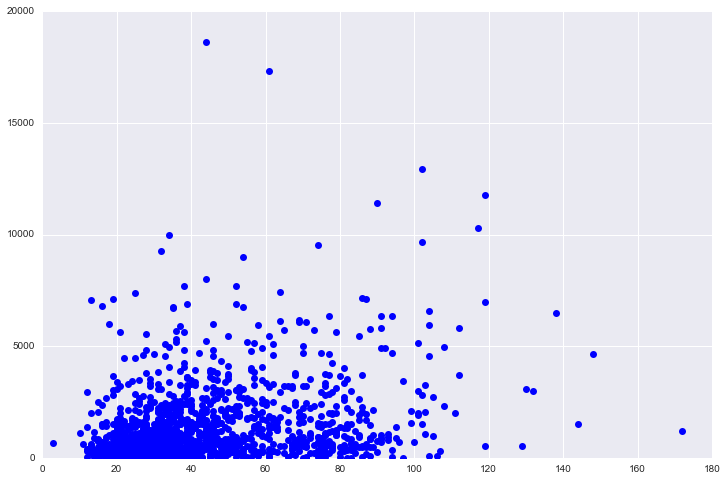

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod1, "apsiii", ax=ax)